In [1]:
%load_ext autoreload

In [1]:
%autoreload 2
import os,sys
import os.path as osp
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import _init_paths
from easydict import EasyDict as edict
import copy
from block_gen import block_gen as bg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sim_knn import sim_knn as sim_knn
from label_denoising import label_denoising as ld
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from root_sim import root_sim as rs
from root_sim.root_sim import experiment_setup
from base.utils import *
import base.plot as base_plot

UsageError: Line magic function `%autoreload` not found.


# Graph Sampling Overview

![Graph Summary](/home/kent/Documents/experiments/label_smoothing_simulation/report/figs/graph_sampling_overview.png)

- A: The *values* of the graph are set to $\{0,1\}$
- B: The *size of the graph* (number of vertices) shrinks to $\widetilde{N}$.

### default simulation parameters

In [65]:
# default simulation parameters
cfg = edict({})

cfg.binary_threshold= 0.5

cfg.base = edict({})
cfg.base.size = 100
cfg.base.random = True
cfg.base.nclasses = 3
cfg.base.label_noise = 0.25
cfg.base.bg_grid_noise = 0.25
cfg.base.grid_transform = None
cfbg = cfg.base

cfg.knn = edict({})
cfg.knn.target = 3
cfg.knn.k = 10
cfk = cfg.knn

cfg.subset = edict({})
cfg.subset.method = 'bernoulli'
cfg.subset.sort = False
cfg.subset.grid_transform = None

cfs = cfg.subset

default_cfg = copy.deepcopy(cfg)

# Experiments on Synthetic Data

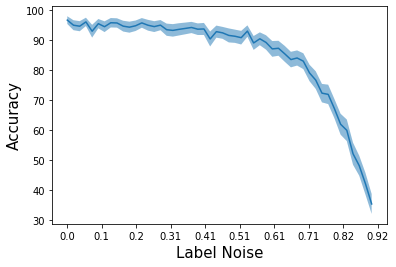

In [24]:
# label noise experiment on entire dataset
label_noise_levels = np.linspace(0,1,50)
label_noise_cfg_list = rs.create_label_noise_experiment_cfg(default_cfg,label_noise_levels)
results = rs.run_experiments(label_noise_cfg_list,ld.maximum_vote_grid,nrepeats=300)
xticklabels = [str(x) for x in np.round(label_noise_levels[::5],2)]
fig,ax,h = rs.plot_results_field(results.acc,xticklabels,"Label Noise")

- Base Grid with Real Values
- No KNN
- Maximum Vote Method

#### ------------------------------------------------------------------------------------------------

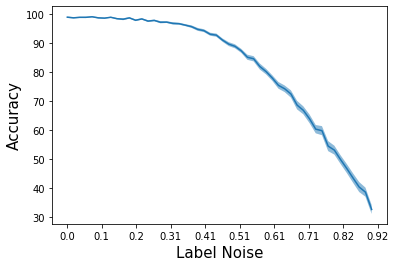

In [16]:
# label noise experiment with base grid using knn
label_noise_levels = np.linspace(0,1,50)
label_noise_cfg_list = rs.create_label_noise_experiment_cfg(default_cfg,label_noise_levels)
results = rs.run_experiments(label_noise_cfg_list,ld.maximum_vote_grid_knn,nrepeats=100)
xticklabels = [str(x) for x in np.round(label_noise_levels[::5],2)]
fig,ax,h = rs.plot_results_field(results.acc,xticklabels,"Label Noise")

- Base Grid with Real Values
- Yes KNN (k = 10)
- Maximum Vote Method

#### ------------------------------------------------------------------------------------------------

In [122]:
label_noise_levels = np.linspace(0,1,50)
bernoulli_thresh_cfg = copy.deepcopy(default_cfg)
bernoulli_thresh_cfg.base.grid_transform = bg.binarize_grid_bernoulli

# can we load a cahced experiment?
basefn = "/home/kent/Documents/experiments/label_smoothing_simulation"
cache_fn = f"{basefn}/output/cache/simple_bernoulli_grid_label_noise_knn_k_max_vote.pkl"
print(cache_fn)
if osp.exists(cache_fn):
    results_bergrid_knn = read_pickle(cache_fn)
else:
    print(f"Cache file {cache_fn} does not exist.")
    print("Running simulation.")
    # run experiment with various knn k
    results_bergrid_knn = []
    k_values = [3, 5, 8, 10, 12, 15, 20, 25, 30, 35, 50]
    for knn_k in k_values:
        bernoulli_thresh_cfg.knn.k = knn_k
        label_noise_cfg_list = rs.create_label_noise_experiment_cfg(bernoulli_thresh_cfg,label_noise_levels)
        results_bgk = rs.run_experiments(label_noise_cfg_list,ld.maximum_vote_grid_knn,nrepeats=50)
        results_bergrid_knn.append(results_bgk)
    write_pickle(results_bergrid_knn,cache_fn)

/home/kent/Documents/experiments/label_smoothing_simulation/output/cache/simple_bernoulli_grid_label_noise_knn_k_max_vote.pkl
Reading pickle file [/home/kent/Documents/experiments/label_smoothing_simulation/output/cache/simple_bernoulli_grid_label_noise_knn_k_max_vote.pkl]
Load successful.


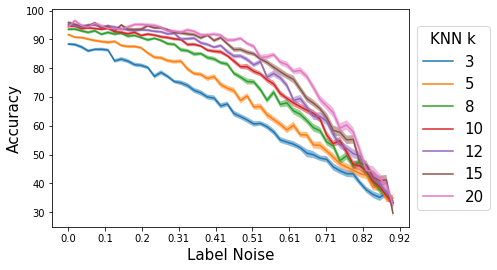

In [123]:
# plot results for stratified k values
handles = []
fig,ax = plt.subplots(figsize=(8,4))
for i,knn_k in enumerate(k_values[::2] + [k_values[-1]]):
    results = results_bergrid_knn[i]
    xticklabels = [str(x) for x in np.round(label_noise_levels[::5],2)]
    _,_,h = rs.plot_results_field(results.acc,xticklabels,"Label Noise",ax=ax)
    handles.append(h[0])
lh = handles
ls = [str(k) for k in k_values]
ax = base_plot.add_legend(ax,lh,ls,"KNN k")

- Base Grid with Binary-Beroulli Values
- Yes KNN (k indicated in legend)
- Maximum Vote Method

#### ------------------------------------------------------------------------------------------------

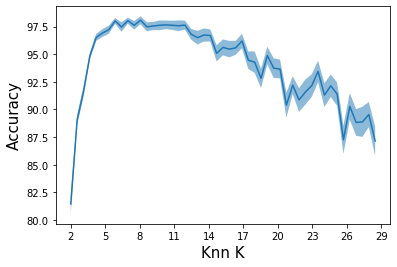

In [73]:
# k for knn experiment
knn_base_cfg = copy.deepcopy(default_cfg)
knn_base_cfg.base.label_noise = 0.25

knn_k_list = np.linspace(2,50,50-2+1)
knn_k_cfg_list = rs.create_knn_k_experiment_cfg(knn_base_cfg,knn_k_list)

results_realgrid = rs.run_experiments(knn_k_cfg_list,ld.maximum_vote_grid_knn,nrepeats=50)
results = results_realgrid
xticklabels = [str(int(x)) for x in knn_k_list[::3]]
fig,ax,h = rs.plot_results_field(results.acc,xticklabels,"Knn K")

- Base Grid with Real Values
- Yes KNN
- Maximum Vote Method

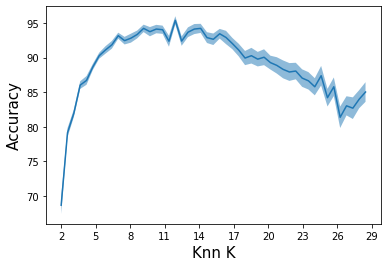

In [72]:
# k for knn experiment
knn_base_cfg = copy.deepcopy(default_cfg)
knn_base_cfg.base.label_noise = 0.25
knn_base_cfg.base.grid_transform = bg.binarize_grid_bernoulli

knn_k_list = np.linspace(2,50,50-2+1)
knn_k_cfg_list = rs.create_knn_k_experiment_cfg(knn_base_cfg,knn_k_list)

results_bernoulligrid = rs.run_experiments(knn_k_cfg_list,ld.maximum_vote_grid_knn,nrepeats=50)
results = results_bernoulligrid
xticklabels = [str(int(x)) for x in knn_k_list[::3]]
fig,ax,h = rs.plot_results_field(results.acc,xticklabels,"Knn K")

- Base Grid with Binary-Beroulli Values
- Yes KNN
- Maximum Vote Method